In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

In [2]:
data = pd.read_csv('RealEstateAU_1000_Samples.csv')

## Data Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            1000 non-null   int64  
 1   TID              1000 non-null   int64  
 2   breadcrumb       1000 non-null   object 
 3   category_name    1000 non-null   object 
 4   property_type    1000 non-null   object 
 5   building_size    280 non-null    object 
 6   land_size        533 non-null    object 
 7   preferred_size   609 non-null    object 
 8   open_date        302 non-null    object 
 9   listing_agency   1000 non-null   object 
 10  price            1000 non-null   object 
 11  location_number  1000 non-null   int64  
 12  location_type    1000 non-null   object 
 13  location_name    1000 non-null   object 
 14  address          988 non-null    object 
 15  address_1        988 non-null    object 
 16  city             1000 non-null   object 
 17  state          

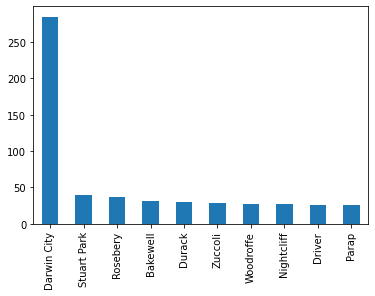

In [4]:
city =  data['city'].value_counts()
city.head(10).plot(kind='bar')
plt.show()

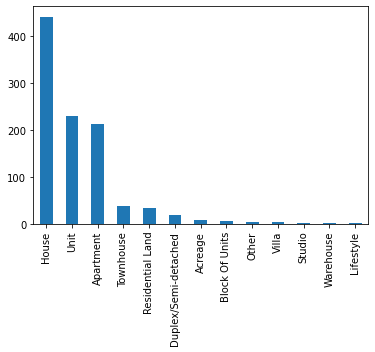

In [5]:
protype =  data['property_type'].value_counts()
protype.head(20).plot(kind='bar')
plt.show()

## Data Cleaning by removing the features which has only NAN values

In [6]:
df = data.drop(['index','TID','breadcrumb','category_name','open_date','listing_agency','location_number','location_type','address','address_1','zip_code','phone','latitude','longitude','building_size','location_name','state'],axis = 1)
df.head()

property_type land_size preferred_size                 price         city  \
0         House       NaN            NaN              $435,000  Darwin City   
1     Apartment       NaN          171m²  Offers Over $320,000  Darwin City   
2          Unit       NaN            NaN              $310,000  Darwin City   
3         House       NaN            NaN              $259,000  Darwin City   
4          Unit       NaN          201m²              $439,000  Darwin City   

  product_depth  bedroom_count  bathroom_count  parking_count  \
0      premiere            2.0             1.0            1.0   
1      premiere            3.0             2.0            2.0   
2      premiere            2.0             1.0            1.0   
3      premiere            1.0             1.0            0.0   
4      premiere            3.0             2.0            2.0   

               RunDate  
0  2022-05-27 15:54:05  
1  2022-05-27 15:54:05  
2  2022-05-27 15:54:05  
3  2022-05-27 15:54:05  
4  2022-05-27 15:54:05

In [7]:
#making rundate index.
df['RunDate'] = pd.to_datetime(df['RunDate']) 
df.set_index('RunDate'  , inplace = True)
df.head()

property_type land_size preferred_size  \
RunDate                                                      
2022-05-27 15:54:05         House       NaN            NaN   
2022-05-27 15:54:05     Apartment       NaN          171m²   
2022-05-27 15:54:05          Unit       NaN            NaN   
2022-05-27 15:54:05         House       NaN            NaN   
2022-05-27 15:54:05          Unit       NaN          201m²   

                                    price         city product_depth  \
RunDate                                                                
2022-05-27 15:54:05              $435,000  Darwin City      premiere   
2022-05-27 15:54:05  Offers Over $320,000  Darwin City      premiere   
2022-05-27 15:54:05              $310,000  Darwin City      premiere   
2022-05-27 15:54:05              $259,000  Darwin City      premiere   
2022-05-27 15:54:05              $439,000  Darwin City      premiere   

                     bedroom_count  bathroom_count  parking_count  
RunDate                                                            
2022-05-27 15:54:05            2.0             1.0            1.0  
2022-05-27 15:54:05            3.0             2.0            2.0  
2022-05-27 15:54:05            2.0             1.0            1.0  
2022-05-27 15:54:05            1.0             1.0            0.0  
2022-05-27 15:54:05            3.0             2.0            2.0

In [8]:
#droping the duplicate values
df1 = df.drop_duplicates(keep='first')
df2=df1.copy()

In [9]:
#data cleaning bby replacing NAN values with the mode of the individual features
land_size_mode = df1['land_size'].mode()[0]
df2['land_size'].fillna(land_size_mode , inplace = True)
preferred_size_mode = df1['preferred_size'].mode()[0]
df2['preferred_size'].fillna(preferred_size_mode , inplace = True)
bedroom_count_mode = df1['bedroom_count'].mode()[0]
df2['bedroom_count'].fillna(bedroom_count_mode , inplace = True)
bathroom_count_mode = df1['bathroom_count'].mode()[0]
df2['bathroom_count'].fillna(bathroom_count_mode , inplace = True)
parking_count_mode = df1['parking_count'].mode()[0]
df2['parking_count'].fillna(parking_count_mode , inplace = True)

## Removing letters from the features to make them numeric values

In [10]:
def convert_ha_to_sqm_for_land_size(df):
    modified_values = []
    for i in df['land_size']:
        if 'ha' in i:
            ha = float(i.strip('ha'))
            modified_values.append(ha * 10000)
             
        else:
            sq_num = re.findall(r'\d+',i)
            joined_sq_num = "".join(sq_num)
            modified_values.append(joined_sq_num)
    return modified_values

df2['land_size'] = convert_ha_to_sqm_for_land_size(df2)

In [11]:
def convert_ha_to_sqm_for_preferred_size(df):
    modified_values = []
    for i in df['preferred_size']:
        if 'ha' in i:
            ha = float(i.strip('ha'))
            modified_values.append(ha * 10000)
             
        else:
            sq_num = re.findall(r'\d+',i)
            joined_sq_num = "".join(sq_num)
            modified_values.append(joined_sq_num)
            
    
    return modified_values

df2['preferred_size'] = convert_ha_to_sqm_for_preferred_size(df2)

In [12]:
price_list = [] 

def price(df):
    for i in df['price'] : 
        price_num = re.findall(r'\d+', i)
        joined_price = "".join(price_num)
        if joined_price != '': 
            price_list.append(joined_price)
        else : 
            price_list.append(np.nan)

    return price_list


df2['price'] = price(df1)

In [13]:
df2['preferred_size'] = pd.to_numeric(df2['preferred_size'])
df2['land_size'] = pd.to_numeric(df2['land_size'])
df2['price'] = pd.to_numeric(df2['price'])

In [14]:
price_mean = df2['price'].mean()
df2['price'] = df2['price'].fillna(price_mean)

In [15]:
df2

property_type  land_size  preferred_size     price  \
RunDate                                                                  
2022-05-27 15:54:05         House    20200.0         20200.0  435000.0   
2022-05-27 15:54:05     Apartment    20200.0           171.0  320000.0   
2022-05-27 15:54:05          Unit    20200.0         20200.0  310000.0   
2022-05-27 15:54:05         House    20200.0         20200.0  259000.0   
2022-05-27 15:54:05          Unit    20200.0           201.0  439000.0   
...                           ...        ...             ...       ...   
2022-05-27 15:54:05         House    91700.0         91700.0       2.0   
2022-05-27 15:54:05         House      600.0           600.0  601000.0   
2022-05-27 15:54:05         House      800.0           800.0  655000.0   
2022-05-27 15:54:05         House      450.0           450.0  675000.0   
2022-05-27 15:54:05          Unit    20200.0           120.0  399000.0   

                            city product_depth  bedroom_count  bathroom_count  \
RunDate                                                                         
2022-05-27 15:54:05  Darwin City      premiere            2.0             1.0   
2022-05-27 15:54:05  Darwin City      premiere            3.0             2.0   
2022-05-27 15:54:05  Darwin City      premiere            2.0             1.0   
2022-05-27 15:54:05  Darwin City      premiere            1.0             1.0   
2022-05-27 15:54:05  Darwin City      premiere            3.0             2.0   
...                          ...           ...            ...             ...   
2022-05-27 15:54:05     Virginia       feature            4.0             3.0   
2022-05-27 15:54:05   Humpty Doo      standard            4.0             2.0   
2022-05-27 15:54:05   Humpty Doo      standard            4.0             2.0   
2022-05-27 15:54:05    Lee Point      standard            4.0             2.0   
2022-05-27 15:54:05  Stuart Park       feature            2.0             2.0   

                     parking_count  
RunDate                             
2022-05-27 15:54:05            1.0  
2022-05-27 15:54:05            2.0  
2022-05-27 15:54:05            1.0  
2022-05-27 15:54:05            0.0  
2022-05-27 15:54:05            2.0  
...                            ...  
2022-05-27 15:54:05            6.0  
2022-05-27 15:54:05            2.0  
2022-05-27 15:54:05            2.0  
2022-05-27 15:54:05            3.0  
2022-05-27 15:54:05            2.0  

[892 rows x 9 columns]

In [16]:
def cat_cols(df) : 
    o = (df.dtypes == 'object')
    object_cols = o[o].index 
    return object_cols
object_cols = cat_cols(df2)

In [17]:
df3 = df2.copy()
ordinal_enc = OrdinalEncoder()
df3[object_cols] = ordinal_enc.fit_transform(df3[object_cols])

## Model Creation 

In [18]:
#sppliting the data
X = df3.drop('price',axis = 1)
Y = df3['price']
x_train,x_test,y_train,y_test = train_test_split(X, Y , test_size = 0.25)

In [21]:
#Training the model
model = LinearRegression()
# Because of the Less data availability after cleaing we are fitting the model 3 times to get good results
model.fit(x_train,y_train)
model.fit(x_train,y_train)
model.fit(x_train,y_train)
#Predicting the test values after training
y_pred = model.predict(x_test)

## Testing tthe model using r2_score metric tester

In [20]:
test_error_score = metrics.r2_score(y_test, y_pred) 
print("R squared Error - Test: ", test_error_score) 

R squared Error - Test:  -0.004546772937208621
